# Las LIDAR 
https://towardsdatascience.com/how-to-automate-lidar-point-cloud-processing-with-python-a027454a536c

In [1]:
from IPython.display import display, HTML

display(HTML(data="""
<style>
    div#notebook-container    { width: 95%; }
    div#menubar-container     { width: 65%; }
    div#maintoolbar-container { width: 99%; }
</style>
"""))

In [2]:
import numpy as np
import laspy as lp
import lasio
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import pandas
import whitebox
import rasterio
from rasterio.plot import show
import earthpy.plot as ep

input_path=".\\"
dataname="swidwie_dense_cloud_crop"
las_np=lp.file.File(input_path+dataname+".las", mode="r")
#point_cloud2 = lasio.read(input_path+dataname+".las")

PROJ: proj_create_from_database: Cannot find proj.db


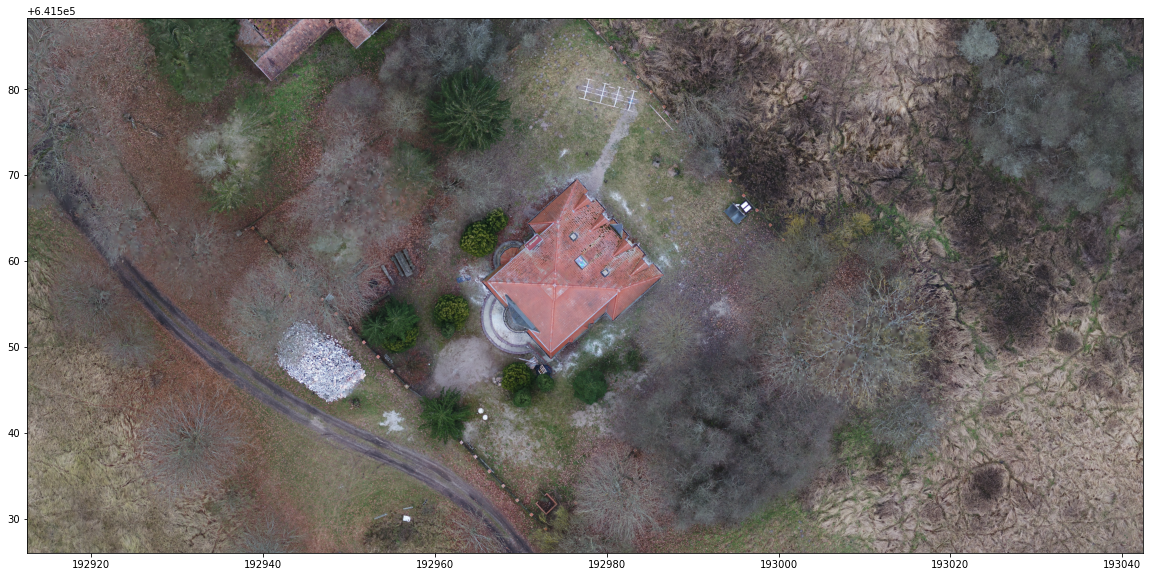

<AxesSubplot:>

In [3]:
src = rasterio.open("swidwie_budynek.tif")
fig, ax = plt.subplots(1, figsize=(20, 12))
show(src.read(), transform=src.transform)

wybieranie losowe punktów

In [4]:
points = np.vstack((las_np.x, las_np.y, las_np.z)).transpose()
num_rows, num_cols = points.shape
print (num_rows, num_cols)

15819619 3


In [5]:
skok=100 #wybieranie co x punkt (slicing)
punkty_skok = points[::skok]
num_rows, num_cols = punkty_skok.shape
print (num_rows, num_cols)


158197 3


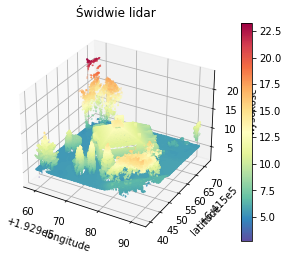

In [6]:
ax = plt.axes(projection='3d')
sc = ax.scatter(punkty_skok[:,0], punkty_skok[:,1], punkty_skok[:,2], c=punkty_skok[:,2] ,s=0.1, marker='o', cmap="Spectral_r")
ax.set_title('Świdwie lidar')
ax.set_ylabel('latitude')
ax.set_xlabel('longitude')
ax.set_zlabel('wysokosc')
plt.colorbar(sc)
plt.rcParams["figure.figsize"] = (20,10)
plt.show()

# grid sampling 
https://towardsdatascience.com/how-to-automate-lidar-point-cloud-processing-with-python-a027454a536c

***Woksel (ang. volumetric picture element, w skrócie voxel) – najmniejszy element budujący przestrzeń w grafice trójwymiarowej.

***Barycentrum (ang. Barycenter) – środek geometryczny 

In [7]:
# Zainicjowanie siatki wokseli
voxel_size=2
nb_vox=np.ceil((np.max(points, axis=0) - np.min(points, axis=0))/voxel_size)
#liczba wokseli w każdej z osi
print(nb_vox)

[17. 16. 11.]


In [8]:
# obliczenie pustych wokseli oraz zliczenie ilosci punktów w każdym wokselu
non_empty_voxel_keys, inverse, nb_pts_per_voxel= np.unique(((points - np.min(points, axis=0)) // voxel_size).astype(int), axis=0, return_inverse=True, return_counts=True)
idx_pts_vox_sorted=np.argsort(inverse)
print('Wypełnione woksele:',len(non_empty_voxel_keys))
print('Maksymalna ilosć punktów na woksel:', np.max(nb_pts_per_voxel), ' Średnia ilosć punktów na woksel: ',np.mean(nb_pts_per_voxel))

Wypełnione woksele: 798
Maksymalna ilosć punktów na woksel: 98227  Średnia ilosć punktów na woksel:  19824.083959899748


In [9]:
voxel_grid={}
grid_barycenter,grid_candidate_center,grid_barycenter=[],[], [] #puste tablice
last_seen=0

for idx,vox in enumerate(non_empty_voxel_keys):
  voxel_grid[tuple(vox)]=points[idx_pts_vox_sorted[last_seen:last_seen+nb_pts_per_voxel[idx]]]
  grid_barycenter.append(np.mean(voxel_grid[tuple(vox)],axis=0))
  grid_candidate_center.append(voxel_grid[tuple(vox)][np.linalg.norm(voxel_grid[tuple(vox)]-np.mean(voxel_grid[tuple(vox)],axis=0),axis=1).argmin()]) #najbliższy punkt do centrum woksela (barycentrum)
  grid_barycenter.append(np.mean(voxel_grid[tuple(vox)],axis=0)) # średnia dla punktów w wokselu
  last_seen+=nb_pts_per_voxel[idx]

In [10]:
np.savetxt(input_path+dataname+"_center_%s.xyz" % (voxel_size), grid_candidate_center, delimiter=";", fmt="%s")
np.savetxt(input_path+dataname+"_barycenter_%s.xyz" % (voxel_size), grid_barycenter, delimiter=";", fmt="%s")

In [11]:
punkty1=pandas.read_csv(input_path+dataname+"_center_2.xyz", delimiter=';')
punkty2=pandas.read_csv(input_path+dataname+"_barycenter_2.xyz", delimiter=';')
punkty1.columns=['x','y','z']
punkty2.columns=['x','y','z']
#print(punkty)
num_rows, num_cols = points.shape
print (num_rows, num_cols)

15819619 3


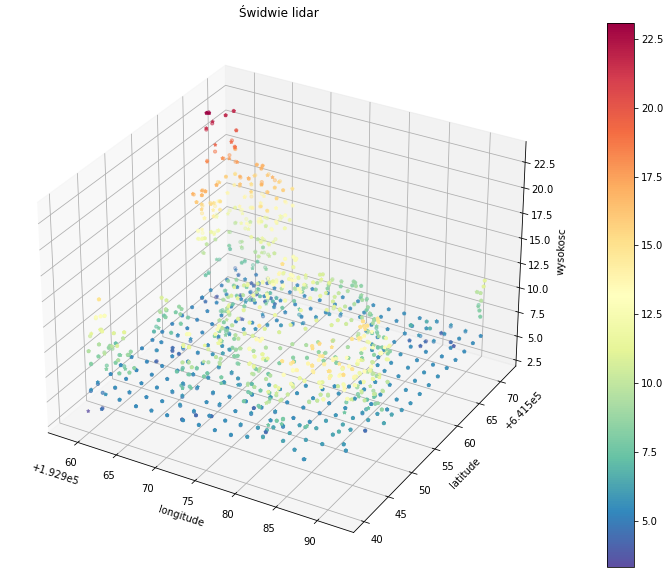

In [12]:
ax = plt.axes(projection='3d')
sc = ax.scatter(punkty1.x, punkty1.y, punkty1.z, c=punkty1.z ,s=10, marker='o', cmap="Spectral_r")
sc2 = ax.scatter(punkty2.x, punkty2.y, punkty2.z, c=punkty2.z ,s=10, marker='*', cmap="Spectral_r")
ax.set_title('Świdwie lidar')
ax.set_ylabel('latitude')
ax.set_xlabel('longitude')
ax.set_zlabel('wysokosc')
plt.colorbar(sc2)
plt.rcParams["figure.figsize"] = (20,10)
plt.show()

<ipython-input-13-ec41a86c395c>:12: RuntimeWarning: invalid value encountered in true_divide
  zi = zi / ile_punktow #średnia


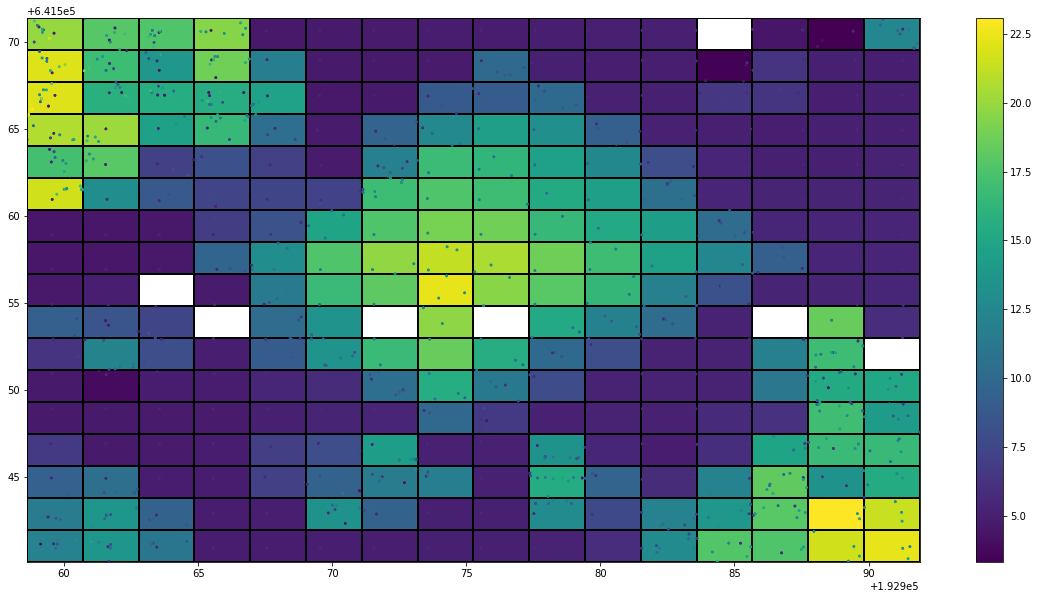

In [13]:
import numpy as np
import matplotlib.pyplot as plt
punkty = punkty2
x = punkty.x 
y = punkty.y 
z = punkty.z
a = int(nb_vox[0])
b = int(nb_vox[1])
zi, yi, xi = np.histogram2d(y, x, bins=(a,b), weights=z, normed=False)
ile_punktow, _, _ = np.histogram2d(y, x, bins=(a,b))

zi = zi / ile_punktow #średnia

zi = np.ma.masked_invalid(zi)

#plot it
fig, ax = plt.subplots()
ax.pcolormesh(xi, yi, zi, edgecolors='black')
scat = ax.scatter(x, y, c=z, s=3)
fig.colorbar(scat)
ax.margins(0.01)

plt.savefig('swidwie.png')
plt.show()


# Wybrane narzędzia PYTHON do analiz chmury punktów (LAS) = whitebox, whitebox-tools
https://hub.gke2.mybinder.org/user/giswqs-whitebox-yizdlkyy/notebooks/examples/whitebox.ipynb#Using-whitebox
https://rdrr.io/rforge/whitebox/man/idw_interpolation.html

In [14]:
import whitebox
import os
import matplotlib.pyplot as plt
import imageio
from rasterio.plot import show
%matplotlib inline 
wbt = whitebox.WhiteboxTools()
data_dir = "C:\Dev\jad3\lab3"
#funkcje whitebox
all_tools = wbt.list_tools()
for index, tool in enumerate(all_tools):
    print("{} {}: {} ...".format(str(index+1).zfill(3), tool, all_tools[tool][:45]))


001 absolute_value: Calculates the absolute value of every cell i ...
002 adaptive_filter: Performs an adaptive filter on an image. ...
003 add: Performs an addition operation on two rasters ...
004 add_point_coordinates_to_table: Modifies the attribute table of a point vecto ...
005 aggregate_raster: Aggregates a raster to a lower resolution. ...
006 and: Performs a logical AND operator on two Boolea ...
007 anova: Performs an analysis of variance (ANOVA) test ...
008 arc_cos: Returns the inverse cosine (arccos) of each v ...
009 arc_sin: Returns the inverse sine (arcsin) of each val ...
010 arc_tan: Returns the inverse tangent (arctan) of each  ...
011 arcosh: Returns the inverse hyperbolic cosine (arcosh ...
012 arsinh: Returns the inverse hyperbolic sine (arsinh)  ...
013 artanh: Returns the inverse hyperbolic tangent (arcta ...
014 ascii_to_las: Converts one or more ASCII files containing L ...
015 aspect: Calculates an aspect raster from an input DEM ...
016 atan2: Returns the 2-

# funkcje

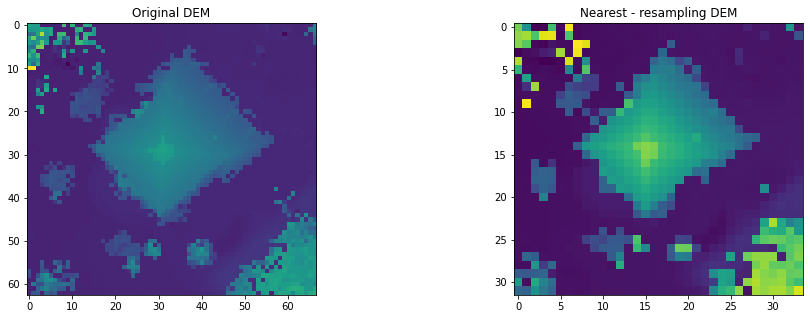

In [15]:
wbt.set_working_dir(data_dir)
wbt.verbose = False
file = "dem_swidwie_budynek.tif"
las = "swidwie_dense_cloud_crop.las"
resolution = 1
# funkcje whiteboxtool https://rdrr.io/rforge/whitebox/man/lidar_nearest_neighbour_gridding.html
wbt.lidar_nearest_neighbour_gridding(las, "las_grid.tif", parameter = "elevation", returns = "all", resolution = resolution,
  radius = 2.5)
wbt.lidar_nearest_neighbour_gridding(las, "las_grid_50cm.tif", parameter = "elevation", returns = "all", resolution = 0.5,
  radius = 2.5)
raster = imageio.imread(os.path.join(data_dir, 'las_grid.tif'))
original = imageio.imread(os.path.join(data_dir, 'las_grid_50cm.tif'))

fig=plt.figure(figsize=(16,11))
ax1 = fig.add_subplot(2, 2, 1)
ax1.set_title('Original DEM')
plt.imshow(original)

ax2 = fig.add_subplot(2, 2, 2)
ax2.set_title('Nearest - resampling DEM')
plt.imshow(raster)
plt.show()

In [19]:
#cieniowanie
wbt.hillshade("swidwie_budynek.tif", 'swidwie_shade.tif', azimuth = 215, altitude = 30, zfactor = 1)

error while writing: Custom { kind: InvalidData, error: "Unknown data type: I16. Photomet interp: RGB" }


0

In [20]:
raster = imageio.imread(os.path.join(data_dir, 'swidwie_shade.tif'))
fig=plt.figure(figsize=(16,11))
plt.imshow(raster)
plt.show()

TiffPages: invalid page offset 78491780


IndexError: Index out of range while reading from tiff file

In [ ]:
wbt.lidar_thin("swidwie_dense_cloud_crop.las", "swidwie_red.las", resolution = 0.1, method = "lowest",
  save_filtered = 1) #zmiana rozdzielczości pliku LAS'''

wbt.lidar_ground_point_filter("swidwie_red.las", "swidwie_ground_red.las", radius = 1, 
                              min_neighbours = 2, slope_threshold = 10, height_threshold = 1, 
                              classify = 2, slope_norm = 0, height_above_ground = 0,) #selekcja punktów powierzchni ziemi

In [ ]:
wbt.lidar_info("swidwie_ground_red.las")

In [ ]:
wbt.filter_lidar_classes('swidwie_ground_red.las', 'swidwie_ground_red_filter.las', exclude_cls = '1',) #usunięcie innych klas

wbt.lidar_remove_outliers('swidwie_ground_red_filter.las', 'swidwie_ground_red_filter.las', radius = 1, elev_diff = 1,
  use_median = 1, classify = 1,) #usunięcie punktów odstających

wbt.lidar_nearest_neighbour_gridding("swidwie_ground_red_filter.las", "swidwie_ground.tif", parameter = "elevation", returns = "all", resolution = 0.1,
  radius = 0.1) #grid z pliku LAS

raster = imageio.imread(os.path.join(data_dir, 'swidwie_ground.tif'))
fig=plt.figure(figsize=(16,11))
plt.imshow(raster)
plt.show()

Punkty koloryzowanie

In [ ]:
from whitebox import WhiteboxTools

wbt = WhiteboxTools()
wbt.work_dir = r"C:\\Users\\48503\\python\\wyklad3_lidar\\"
in_lidar = "swidwie_dense_cloud_crop.las"
in_image = "swidwie_budynek.tif"
out_lidar = "swidwie_colour.las"
wbt.lidar_colourize(in_lidar, in_image, out_lidar) 